In [1]:
# Sample from https://www.kaggle.com/fkdplc/celeba-dcgan-for-generating-faces 
import numpy as np
import pandas as pd
import os

#PIC_DIR = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
PIC_DIR = 'kaggle_celeba/img_align_celeba/img_align_celeba/'
len(os.listdir(PIC_DIR))

202599

In [2]:
from PIL import Image
from tqdm import tqdm

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))

images = np.array(images) / 255
images.shape

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:21<00:00, 70.77it/s]


(10000, 128, 128, 3)

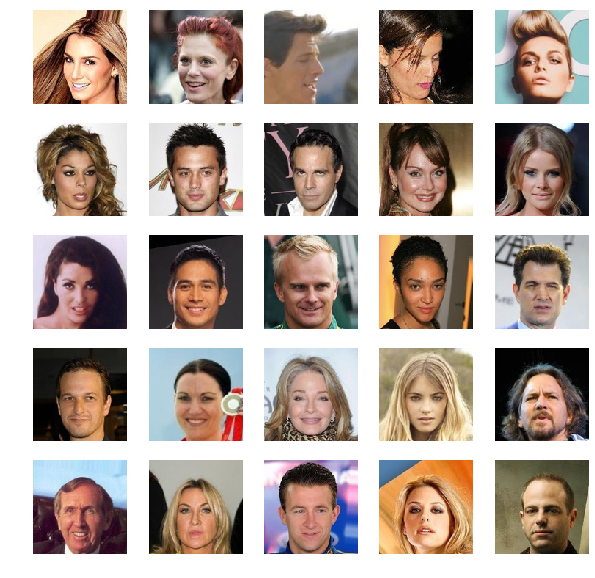

In [4]:
from matplotlib import pyplot as plt

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [5]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator

Using TensorFlow backend.


In [6]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [7]:
import time

iters = 20000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

50/20000: d_loss: 0.7017,  a_loss: 0.7274.  (4.8 sec)
100/20000: d_loss: 0.6300,  a_loss: 0.7714.  (4.7 sec)
150/20000: d_loss: 0.5940,  a_loss: 0.9011.  (4.7 sec)
200/20000: d_loss: 0.6019,  a_loss: 1.0770.  (5.0 sec)
250/20000: d_loss: 0.6551,  a_loss: 0.7110.  (4.8 sec)
300/20000: d_loss: 0.6718,  a_loss: 1.0247.  (4.7 sec)
350/20000: d_loss: 0.6580,  a_loss: 0.9135.  (4.6 sec)
400/20000: d_loss: 0.6678,  a_loss: 0.9702.  (4.8 sec)
450/20000: d_loss: 0.6579,  a_loss: 0.8715.  (4.8 sec)
500/20000: d_loss: 0.6737,  a_loss: 0.8812.  (4.8 sec)
550/20000: d_loss: 0.6650,  a_loss: 0.8586.  (4.7 sec)
600/20000: d_loss: 0.7274,  a_loss: 0.9164.  (4.7 sec)
650/20000: d_loss: 0.7379,  a_loss: 0.9339.  (5.0 sec)
700/20000: d_loss: 0.6948,  a_loss: 0.9191.  (4.8 sec)
750/20000: d_loss: 0.6413,  a_loss: 0.8262.  (4.7 sec)
800/20000: d_loss: 0.5966,  a_loss: 1.0170.  (4.7 sec)
850/20000: d_loss: 0.6354,  a_loss: 0.9480.  (4.8 sec)
900/20000: d_loss: 0.6735,  a_loss: 0.8163.  (4.8 sec)
950/20000: 

7400/20000: d_loss: 0.6813,  a_loss: 0.7815.  (5.0 sec)
7450/20000: d_loss: 0.6811,  a_loss: 1.0273.  (4.8 sec)
7500/20000: d_loss: 0.6537,  a_loss: 0.8120.  (4.7 sec)
7550/20000: d_loss: 0.6833,  a_loss: 0.7560.  (4.7 sec)
7600/20000: d_loss: 0.6643,  a_loss: 0.7877.  (4.8 sec)
7650/20000: d_loss: 0.6960,  a_loss: 1.0093.  (4.8 sec)
7700/20000: d_loss: 0.6839,  a_loss: 0.7773.  (4.8 sec)
7750/20000: d_loss: 0.6608,  a_loss: 0.8361.  (4.7 sec)
7800/20000: d_loss: 0.6644,  a_loss: 0.8219.  (4.7 sec)
7850/20000: d_loss: 0.6798,  a_loss: 0.7439.  (5.0 sec)
7900/20000: d_loss: 0.6791,  a_loss: 0.8748.  (4.7 sec)
7950/20000: d_loss: 0.6928,  a_loss: 0.9128.  (4.8 sec)
8000/20000: d_loss: 0.6506,  a_loss: 0.8441.  (4.7 sec)
8050/20000: d_loss: 0.7626,  a_loss: 0.8760.  (4.9 sec)
8100/20000: d_loss: 0.7033,  a_loss: 0.9434.  (6.2 sec)
8150/20000: d_loss: 0.7217,  a_loss: 0.8770.  (4.7 sec)
8200/20000: d_loss: 0.6933,  a_loss: 0.8423.  (4.7 sec)
8250/20000: d_loss: 0.7028,  a_loss: 0.8396.  (4

14650/20000: d_loss: 0.7081,  a_loss: 0.9018.  (4.7 sec)
14700/20000: d_loss: 0.6579,  a_loss: 0.9302.  (4.7 sec)
14750/20000: d_loss: 0.7658,  a_loss: 1.0109.  (4.7 sec)
14800/20000: d_loss: 0.6777,  a_loss: 0.8072.  (4.8 sec)
14850/20000: d_loss: 0.7268,  a_loss: 1.0658.  (4.9 sec)
14900/20000: d_loss: 0.6261,  a_loss: 0.8442.  (4.7 sec)
14950/20000: d_loss: 0.6433,  a_loss: 0.7352.  (4.7 sec)
15000/20000: d_loss: 0.6757,  a_loss: 0.9197.  (4.8 sec)
15050/20000: d_loss: 0.6609,  a_loss: 0.9858.  (4.7 sec)
15100/20000: d_loss: 0.6793,  a_loss: 0.8515.  (4.6 sec)
15150/20000: d_loss: 0.6506,  a_loss: 0.8784.  (4.6 sec)
15200/20000: d_loss: 0.6821,  a_loss: 0.8564.  (4.8 sec)
15250/20000: d_loss: 0.6429,  a_loss: 0.6925.  (4.8 sec)
15300/20000: d_loss: 0.6521,  a_loss: 1.0348.  (4.7 sec)
15350/20000: d_loss: 0.6606,  a_loss: 0.7242.  (4.9 sec)
15400/20000: d_loss: 0.5939,  a_loss: 0.8890.  (4.7 sec)
15450/20000: d_loss: 0.6440,  a_loss: 0.8849.  (4.8 sec)
15500/20000: d_loss: 0.5853,  a

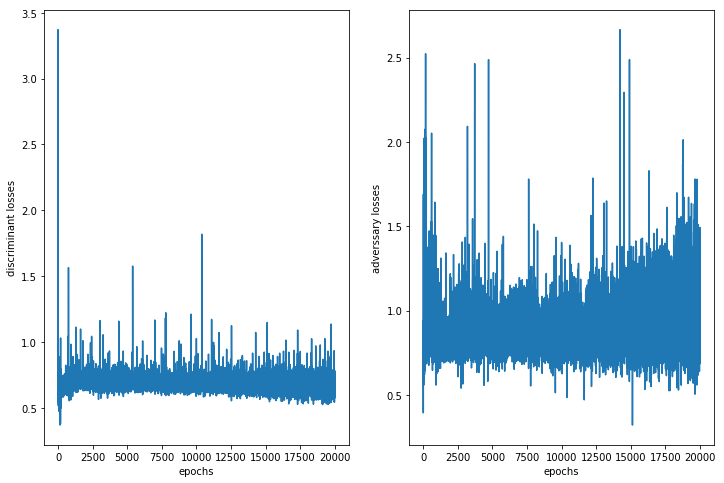

In [8]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adverssary losses')
plt.show()

In [9]:
import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
#shutil.rmtree(RES_DIR)